### **MONTANDO E DEFININDO PACTH**

> *Sessão inicial dedicada a conexão com os dados MNIST que estão salvos no googleDrive e separação das imagens e seus respectivos rótulos.*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = '/content/drive/MyDrive/3_DOUTORADO/_UFC/Disciplinas/Inteligencia Computacional Aplicada/MNIST'
files = os.listdir(path)
path_REV = '/content/drive/MyDrive/3_DOUTORADO/_UFC/Disciplinas/Inteligencia Computacional Aplicada/Real estate valuation.xlsx'

Mounted at /content/drive


### **TRATAMENTO DOS DADOS**

> *Os dados de treino e teste são carregados, em seguida, normalizados para o intervalo [-1,0 +1,0]. O dataset possui imagens de 28x28, transformadas em vetores de 784 caracteristicas, ou seja, as imagens foram convertidas de 2D para 1D.*

In [3]:
import numpy as np
import time

def load_mnist(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)

    labels = data[:, 0].astype(int)         # Coluna 0 - rótulo
    images = data[:, 1:].astype(int)        # demais colunas representam a imagem (28x28 = 784 pixels)

    return images, labels

In [4]:
X_treino, Y_treino = load_mnist(path + '/mnist_train.csv')
X_teste, Y_teste   = load_mnist(path + '/mnist_test.csv')

X_treino_norm = X_treino.astype('float32').copy(); X_treino_norm /= 255.0;
X_teste_norm  = X_teste.astype('float32').copy();  X_teste_norm /= 255.0;

print(f"{len(X_treino_norm)} imagens de treino e {len(X_teste)} de teste.")
print(f"Na seguinte Formatação: {X_treino_norm.shape} e {X_teste_norm.shape}.")

60000 imagens de treino e 10000 de teste.
Na seguinte Formatação: (60000, 784) e (10000, 784).


### **APLICANDO PCA**

> PCA ajuda a reduzir a quantidade de dados mantendo as variáveis mais importantes, o que pode acelerar o treinamento e melhorar a generalização.

In [5]:
def aplicar_pca(treino, teste, n_componentes):
    mean = np.mean(treino, axis=0)       # Calcula a média
    treino_center = treino - mean     # centraliza os dados de treino

    mean = np.mean(teste, axis=0)        # Calcula a média
    teste_center = teste - mean       # centraliza os dados de treino

    cov_matrix = np.cov(treino_center, rowvar=False)           # Calcula a Matriz de covariância das caracteristica
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)   # Separa os autovalores e autovetores

    sorted_indices = np.argsort(-eigenvalues)       # Ordena os índices - decrescente
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    componentes_principais = eigenvectors[:, :n_componentes]

    # Projeção dos dados no novo espaço de componentes
    treino_pca = treino_center @ componentes_principais
    teste_pca = teste_center @ componentes_principais

    # Calculo a variância explicada
    total_variancia = np.sum(eigenvalues)
    explained_variance_ratio = (eigenvalues[:n_componentes] / total_variancia) * 100

    # Exibir os resultados
    return treino_pca, teste_pca, componentes_principais, np.round(np.sum(explained_variance_ratio), 2)

In [6]:
X_treino_pca, X_teste_pca, compoentes, variancia_total = aplicar_pca( X_treino_norm, X_teste_norm, 180)
print(f"Variância explicada dos {compoentes.shape[1]} componentes: {variancia_total}%" )

Variância explicada dos 180 componentes: 96.03%


### **CLASSIFICADOR LINEAR DOS MÍNIMOS QUADRADOS**

> *O objetivo desse classificador é encontrar uma reta (ou hiperplano) que minimize a soma dos quadrados dos erros entre a saída prevista e a saída desejada. Essa técnica é baseada no princípio dos mínimos quadrados ordinários (OLS – Ordinary Least Squares). Para tal solução podemos **calcular o vetor de pesos (W) diretamente sem precisar iterar**, como acontece em métodos de otimização como o gradiente descendente.*

In [7]:
class Classificador_MMQ:
    def __init__(self):
        self.weights   = None
        self.n_classes = 10                             # Classes de saida [MNIST]

    def fit(self, X, y):
        X_bias = np.c_[np.ones(X.shape[0]), X]          # Concatena a coluna de 1`s [bias] com X
        y_categ = np.zeros((y.size, self.n_classes))    # Categoriza os rótulos
        y_categ[np.arange(y.size), y] = 1               # ...

        # Resolve a equação dos mínimos quadrados: W = (X^T X)^-1 X^T y [Encontra os pesos]
        self.weights = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y_categ

    def predict(self, X):
        X_bias = np.c_[np.ones(X.shape[0]), X]
        predictions = X_bias @ self.weights
        return np.argmax(predictions, axis=1)

In [8]:
# Instanciando e treinando o classificador MMQ SEM PCA
MinimosQuadrados_norm = Classificador_MMQ()
#
start_time = time.perf_counter()
MinimosQuadrados_norm.fit(X_treino_norm, Y_treino)    # treino
predicao = MinimosQuadrados_norm.predict(X_teste_norm) # teste
end_time = time.perf_counter()
tempo_norm = end_time - start_time

# Instanciando e treinando o classificador MMQ COM PCA
MinimosQuadrados_pca = Classificador_MMQ()
#
start_time = time.perf_counter()
MinimosQuadrados_pca.fit(X_treino_pca, Y_treino)    # treino
predicao_pca = MinimosQuadrados_pca.predict(X_teste_pca) # teste
end_time = time.perf_counter()
tempo_pca = end_time - start_time

# Predições
acuracia_norm = np.mean(predicao == Y_teste) * 100
erro_norm = 100 - acuracia_norm
#
acuracia_pca = np.mean(predicao_pca == Y_teste) * 100
erro_pca = 100 - acuracia_pca

print(f"Classificador Linear de Mínimos Quadrados")
print(f"Análise sem PCA: tempo: {tempo_norm:.3f} seg // Tx de Erro: {erro_norm:.3f}% ")
print(f"Análise com PCA: tempo: {tempo_pca:.3f} seg // Tx de Erro: {erro_pca:.3f}% ")

Classificador Linear de Mínimos Quadrados
Análise sem PCA: tempo: 4.838 seg // Tx de Erro: 13.970% 
Análise com PCA: tempo: 0.312 seg // Tx de Erro: 13.910% 


### **ADALINE**

> *O Adaline (Neurônio Linear Adaptativo) é um classificador linear que utiliza uma abordagem semelhante ao Perceptron, porém com função de custo diferente para encontrar o hiperplano que separa as classes. O Adaline usa a **função de ativação linear para calcular a saída e minimiza a soma dos erros quadráticos durante o treinamento**.*


In [9]:
class Classificador_Adaline:
    def __init__(self, eta=0.01, n_classes=10, epocas=50):
        self.n_classes = n_classes
        self.eta = eta
        self.epocas = epocas
        self.weights = None

    def fit(self, X, y):
        self.weights = np.random.randn(X.shape[1]+1, self.n_classes)  # Inicializa matriz de pesos aleatoriamente
        X_bias = np.c_[np.ones(X.shape[0]), X]                        # Adiciona coluna de 1's - bias

        # Saída Categorizada
        y_categ = np.zeros((y.size, self.n_classes))
        y_categ[np.arange(y.size), y] = 1

        # Treinamento
        erro_medio_por_epoca = []
        for i in range(self.epocas):
            linear_output = X_bias @ self.weights         # Calcula a ativação linear [X W.T]
            predictions = self.sigmoid(linear_output)     # Aplica a função de ativação sigmoidal
            erro = y_categ - predictions                  # Calcula o erro
            self.weights += self.eta * X_bias.T @ erro    # Atualiza os pesos

            erro_medio = np.mean(np.abs(erro))
            erro_medio_por_epoca.append(erro_medio)
        return erro_medio_por_epoca

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        X_bias = np.c_[np.ones(X.shape[0]), X]            # Adiciona coluna de bias
        linear_output = X_bias @ self.weights
        predictions = self.sigmoid(linear_output)
        return np.argmax(predictions, axis=1)

In [10]:
import matplotlib.pyplot as plt

# Instânciando e Treinando Adaline, usando dataset MNIST
# Com saída categorizada, n_classes=10.

# SEM PCA
adaline_classifier_norm = Classificador_Adaline(eta=0.0001, n_classes=10, epocas=30)

start_time = time.perf_counter()
erro_medio_norm = adaline_classifier_norm.fit(X_treino_norm, Y_treino)
y_pred_norm = adaline_classifier_norm.predict(X_teste_norm)
end_time = time.perf_counter()
tempo_norm= end_time - start_time

# COM PCA
adaline_classifier_pca = Classificador_Adaline(eta=0.001, epocas=30)

start_time = time.perf_counter()
erro_medio_pca = adaline_classifier_pca.fit(X_treino_pca, Y_treino)
y_pred_pca = adaline_classifier_pca.predict(X_teste_pca)
end_time = time.perf_counter()
tempo_pca= end_time - start_time

# Avaliando a precisões
acuracia_norm = np.mean(y_pred_norm == Y_teste) * 100
erro_norm     = 100 - acuracia_norm

acuracia_pca  = np.mean(y_pred_pca == Y_teste) * 100
erro_pca      = 100 - acuracia_pca

# Resultados
print(f"Classificador Adaline com Sigmoid")
print(f"Análise sem PCA: tempo: {tempo_norm:.3f} seg // Tx de Erro: {erro_norm:.3f}% ")
print(f"Análise com PCA: tempo: {tempo_pca:.3f} seg // Tx de Erro: {erro_pca:.3f}% ")

Classificador Adaline com Sigmoid
Análise sem PCA: tempo: 14.217 seg // Tx de Erro: 28.490% 
Análise com PCA: tempo: 2.806 seg // Tx de Erro: 10.310% 


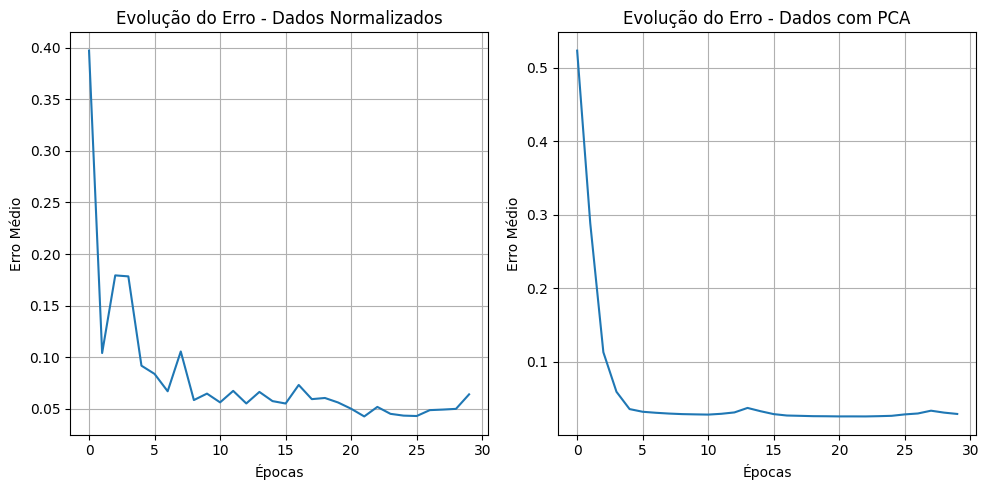

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico 1
axs[0].plot(erro_medio_norm)
axs[0].set_title('Evolução do Erro - Dados Normalizados')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Erro Médio')
axs[0].grid(True)

# Gráfico 2
axs[1].plot(erro_medio_pca)
axs[1].set_title('Evolução do Erro - Dados com PCA')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Erro Médio')
axs[1].grid(True)

# Exibir
plt.tight_layout()
plt.show()

### **MLP - 2 Layers NN, 300 neurônios**

> *A MLP (Multi-Layer Perceptron), é uma extensão de redes neurais simples, como o Adaline. A MLP usa múltiplas camadas de neurônios (camadas ocultas), totalmente interconectada, com funções de ativação não lineares para "aprender" representações mais complexas.*

> *A classe implementa uma única camada oculta com funções de ativação sigmoide na camada oculta e softmax na camada de saída, usando a retropropagação para o treinamento.*

> *Em relação aos dados, foram utilizados técnicas de normalização e PCA.*


In [12]:
import numpy as np

class classificador_MLP2:
    def __init__(self, size_input, size_oculta_1, size_oculta_2, size_output, eta=0.01, epochs=50):
        self.size_input   = size_input + 1    # +1 para o bias
        self.size_oculta_1= size_oculta_1 + 1  # +1 para o bias
        self.size_oculta_2= size_oculta_2 + 1  # +1 para o bias
        self.size_output  = size_output      # camada de saida categorizada [10]
        self.eta = eta                      # tx de aprendizado
        self.epochs = epochs                # repeticoes

        # Inicializa os pesos entre as camadas
        self.p_input_camada1   = np.random.randn(self.size_input,    self.size_oculta_1 - 1) * 0.1   # Pesos entre camada de entrada e oculta_1
        self.p_camada1_camada2 = np.random.randn(self.size_oculta_1, self.size_oculta_2 - 1) * 0.1   # Pesos entre oculta_1 e oculta_2
        self.p_camada2_output  = np.random.randn(self.size_oculta_2, self.size_output      ) * 0.1   # Pesos entre oculta_2 e saída


    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivada(self, z):
        return np.where(z > 0, 1, 0)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivada(self, z):
        return z * (1 - z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Evita overflow numérico
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        # Adiciona bias às entradas
        X_bias = np.c_[np.ones(X.shape[0]), X]

        # Converte os rótulos (y) para one-hot encoding
        y_categ = np.zeros((y.size, self.size_output))
        y_categ[np.arange(y.size), y] = 1

        # Loop de treinamento
        for epoch in range(self.epochs):
            ######### Forward propagation #########
            # camada oculta 1
            input_camada_1  = X_bias @ self.p_input_camada1                                       # Calcula os valores da camada oculta
            output_camada_1 = np.c_[np.ones(input_camada_1.shape[0]), self.relu(input_camada_1)]  # aplica a funcao de ativaçao
            # camada oculta 2
            input_camada_2  = output_camada_1 @ self.p_camada1_camada2                            # Calcula os valores da camada oculta
            output_camada_2 = np.c_[np.ones(input_camada_2.shape[0]), self.relu(input_camada_2)]  # aplica a funcao de ativaçao
            # camada saida
            input_final = output_camada_2 @ self.p_camada2_output                                 # calcula os valores da camada de saida
            predictions = self.softmax(input_final)                                               # aplica a funcao de ativacao

            # Cálculo do erro (MSE)
            erro = y_categ - predictions
            d_output = erro

            ######### Backpropagation #########
            # Gradiente Oculta 2
            d_camada_2 = (d_output @ self.p_camada2_output.T) * self.relu_derivada(output_camada_2)
            d_camada_2 = d_camada_2[:, 1:]  # Ignora o bias na retropropagação
            # Gradiente Oculta 1
            d_camada_1 = (d_camada_2 @ self.p_camada1_camada2.T) * self.relu_derivada(output_camada_1)
            d_camada_1 = d_camada_1[:, 1:]  # Ignora o bias na retropropagação

            # Atualização dos pesos
            self.p_camada2_output  += self.eta * output_camada_2.T @ d_output
            self.p_camada1_camada2 += self.eta * output_camada_1.T @ d_camada_2
            self.p_input_camada1   += self.eta * X_bias.T @ d_camada_1

            # Mostra o erro a cada época
            erro_epoca = np.mean(erro ** 2)
            print(f'Época {epoch+1}/{self.epochs}, erro: {erro_epoca:.3f}')


    def predict(self, X):
        # Adiciona bias às entradas
        X_bias = np.c_[np.ones(X.shape[0]), X]

        # Forward propagation para predição
        input_camada_1  = X_bias @ self.p_input_camada1
        output_camada_1 = np.c_[np.ones(input_camada_1.shape[0]), self.relu(input_camada_1)]

        input_camada_2  = output_camada_1 @ self.p_camada1_camada2
        output_camada_2 = np.c_[np.ones(input_camada_2.shape[0]), self.relu(input_camada_2)]

        input_final = output_camada_2 @ self.p_camada2_output
        predictions = self.softmax(input_final)

        return np.argmax(predictions, axis=1)

In [13]:
# Cria o modelo MLP com duas camadas ocultas
#input_size = 28 * 28  # Cada imagem tem 784 pixels
input_size =X_treino_pca.shape[1]
hidden_size1 = 300     # Primeira camada oculta
hidden_size2 = 300    # Segunda camada oculta
output_size = 10       # 10 classes (0-9)

mlp2 = classificador_MLP2(input_size, hidden_size1, hidden_size2, output_size, eta=0.00001, epochs=100)

# Treina o modelo
mlp2.fit(X_treino_pca, Y_treino)

# Faz previsões no conjunto de teste
predictions = mlp2.predict(X_teste_pca)

# Calcula a acurácia no conjunto de teste
accuracy = np.mean(predictions == Y_teste)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

Época 1/100, erro: 0.103
Época 2/100, erro: 0.081
Época 3/100, erro: 0.081
Época 4/100, erro: 0.053
Época 5/100, erro: 0.040
Época 6/100, erro: 0.030
Época 7/100, erro: 0.027
Época 8/100, erro: 0.025
Época 9/100, erro: 0.023
Época 10/100, erro: 0.022
Época 11/100, erro: 0.021
Época 12/100, erro: 0.021
Época 13/100, erro: 0.020
Época 14/100, erro: 0.021
Época 15/100, erro: 0.020
Época 16/100, erro: 0.020
Época 17/100, erro: 0.019
Época 18/100, erro: 0.018
Época 19/100, erro: 0.017
Época 20/100, erro: 0.016
Época 21/100, erro: 0.015
Época 22/100, erro: 0.014
Época 23/100, erro: 0.014
Época 24/100, erro: 0.014
Época 25/100, erro: 0.013
Época 26/100, erro: 0.013
Época 27/100, erro: 0.013
Época 28/100, erro: 0.013
Época 29/100, erro: 0.012
Época 30/100, erro: 0.012
Época 31/100, erro: 0.012
Época 32/100, erro: 0.012
Época 33/100, erro: 0.012
Época 34/100, erro: 0.012
Época 35/100, erro: 0.011
Época 36/100, erro: 0.011
Época 37/100, erro: 0.011
Época 38/100, erro: 0.011
Época 39/100, erro: 0

###
###########################################################

Segunda Parte
###########################################################

### **Regreção Linear - MMQ**

> .

In [14]:
import numpy as np
import pandas as pd

class Regressao_MMQ:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        X_bias = np.c_[np.ones(X.shape[0]), X]    # Adicionar o bias (coluna de 1s)

        # Resolver a equação dos mínimos quadrados: W = (X^T X)^-1 X^T y
        self.weights = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y

    def predict(self, X):
        X_bias = np.c_[np.ones(X.shape[0]), X]    # Adicionar o bias na matriz de entrada

        # Fazer a previsão
        predictions = X_bias @ self.weights
        return predictions

In [15]:
data = pd.read_excel(path_REV)
data = data.drop(columns=['No'])    # Remover a primeira coluna

# Separar variáveis independentes (X) e dependente (y)
X = data.drop(columns=['Y house price of unit area']).values
y = data['Y house price of unit area'].values

modelo = Regressao_MMQ()

modelo.fit(X, y)                    # Treina o modelo
y_pred_linear = np.round(modelo.predict(X), 3)          # Faz previsões

# Exibir as primeiras 10 previsões e os pesos do modelo
#print("Previsões para os primeiros 10 exemplos:", y_pred_linear[:10])
#print("Pesos do modelo:", modelo.weights)


### **Regreção - MLP 1 Lauyer**

> .

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Função de ativação ReLU
def relu(x):
    return np.maximum(0, x)

# Derivada da função ReLU para o backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Função de perda (MSE - Mean Squared Error)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivada da função de perda MSE
def mse_derivative(y_true, y_pred):
    return -2 * (y_true - y_pred) / y_true.size

# Classe para a implementação do MLP com 1 camada oculta
class Regressao_MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Inicialização dos pesos
        self.weights_hidden = np.random.randn(input_size, hidden_size) * 0.1
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_output = np.random.randn(hidden_size, output_size) * 0.1
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def forward(self, X):
        # Forward pass (camada oculta)
        self.z_hidden = np.dot(X, self.weights_hidden) + self.bias_hidden
        self.a_hidden = relu(self.z_hidden)

        # Forward pass (camada de saída)
        self.z_output = np.dot(self.a_hidden, self.weights_output) + self.bias_output
        return self.z_output  # saída linear para regressão

    def backward(self, X, y_true, y_pred):
        # Backpropagation (saída -> oculta)
        error_output = mse_derivative(y_true, y_pred)
        d_weights_output = np.dot(self.a_hidden.T, error_output)
        d_bias_output = np.sum(error_output, axis=0, keepdims=True)

        # Backpropagation (oculta -> entrada)
        error_hidden = np.dot(error_output, self.weights_output.T) * relu_derivative(self.z_hidden)
        d_weights_hidden = np.dot(X.T, error_hidden)
        d_bias_hidden = np.sum(error_hidden, axis=0, keepdims=True)

        # Atualizar pesos
        self.weights_output -= self.learning_rate * d_weights_output
        self.bias_output -= self.learning_rate * d_bias_output
        self.weights_hidden -= self.learning_rate * d_weights_hidden
        self.bias_hidden -= self.learning_rate * d_bias_hidden

    def fit(self, X, y, epochs=1000):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = mean_squared_error(y, y_pred)    # Calcular perda
            self.backward(X, y, y_pred)             # Backpropagation
            # Mostrar perda a cada 100 épocas
            if (epoch + 1) % 100 == 0:
                print(f'Época {epoch + 1}, Perda: {loss:.4f}')

    def predict(self, X):   # Previsão usando a rede treinada
        return self.forward(X)

In [17]:
# Carregar o conjunto de dados e remove a primeira coluna
data = pd.read_excel(path_REV)
data = data.drop(columns=['No'])

# Separa Caracteristicas do Taarget
X = data.drop(columns=['Y house price of unit area']).values
y = data['Y house price of unit area'].values

# Normaliza os dados
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = y.reshape(-1, 1)

mlp = Regressao_MLP(input_size=X.shape[1], hidden_size=5, output_size=1, learning_rate=0.0001)

mlp.fit(X, y, epochs=1500)
y_pred_mlp = mlp.predict(X)

Época 100, Perda: 1563.0080
Época 200, Perda: 1479.9154
Época 300, Perda: 1303.2373
Época 400, Perda: 864.6414
Época 500, Perda: 347.9838
Época 600, Perda: 170.9778
Época 700, Perda: 121.0671
Época 800, Perda: 92.8293
Época 900, Perda: 79.0575
Época 1000, Perda: 72.7326
Época 1100, Perda: 69.7542
Época 1200, Perda: 68.2757
Época 1300, Perda: 67.5098
Época 1400, Perda: 67.0757
Época 1500, Perda: 66.8095


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
rmse_mlp = np.sqrt(mean_squared_error(y, y_pred_mlp))
r2_linear = r2_score(y, y_pred_linear)
r2_mlp = r2_score(y, y_pred_mlp)

print(f"R² MLP: {round(r2_mlp, 4)}")
print(f"RMSE MLP: {rmse_mlp}")
print(f"R² Regressão Linea: {round(r2_linear, 4)}")
print(f"RMSE Regressão Linear: {rmse_linear}")



R² MLP: 0.6383
RMSE MLP: 8.173577740647259
R² Regressão Linea: 0.5777
RMSE Regressão Linear: 8.831207655228047
